## IBM Data Science Capstone Project

**In this project we will look for the price range for a new restaurant.** We are going to check the **food venues** in the center of the major cities of **Morocco**. We will use their rating, food type and position of the city and within the city to create a model that will predict the best price range for your new restaurant in this area.

we first install all needed libraries outside the default packages of python (drop the comments)

In [1]:
# !pip install geopy
# !pip install folium
# !pip install bs4
# !pip install sklearn

Let's import some libraries

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests
from bs4 import BeautifulSoup

The table of the major Moroccan cities from wikipedia

In [3]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Morocco'
html = requests.get(wiki_url).text
soup = BeautifulSoup(html, 'lxml')

In [4]:
my_table = soup.find('table', {'class' : 'wikitable sortable'})

Scrapping the Wikipedia page

In [5]:
Rank = []
City = []
Estimate = []
Region = []
for row in my_table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 4:
        Rank.append(cells[0].find(text = True))
        City.append(cells[1].find(text = True))
        Estimate.append(cells[2].find(text = True))
        Region.append(cells[3].find(text = True))


for i in Estimate:
    j = i.strip()
    Estimate[Estimate.index(i)] = j
for i in Estimate:
    i = str(i)
    j = i.replace(',', '')
    Estimate[Estimate.index(i)] = int(j)

Cleaning and sorting, then choosing only the major cities with more than 200,000 population

In [6]:
Morocco_df = pd.DataFrame({'Rank' : Rank, 'City': City, 'Estimate' : Estimate, 'Region' : Region})

Morocco_df = Morocco_df.drop(['Rank', 'Region'], axis = 1)

Morocco_df = Morocco_df[Morocco_df.Estimate > 200000]


Getting coordinations 

In [9]:
Latitude = []
Longitude = []

for i in Morocco_df.City:
    address = i + ', Morocco'
    geolocator = Nominatim(user_agent = 'my-application')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    Latitude.append(latitude)
    Longitude.append(longitude)
    
Morocco_df['Latitude'] = Latitude
Morocco_df['Longitude'] = Longitude

In [10]:
Morocco_df

,City,Estimate,Latitude,Longitude
0,Casablanca,3359818,33.595063,-7.618777
1,Fez,1112072,34.034653,-5.016193
2,Tangier,947952,35.777103,-5.803792
3,Marrakesh,928850,31.625826,-7.989161
4,Salé,890403,34.015678,-6.756799
5,Meknes,632079,33.897812,-5.531984
6,Rabat,577827,34.022405,-6.834543
7,Oujda,494252,34.677874,-1.929306
8,Kenitra,431282,34.264570,-6.570169
9,Agadir,421844,30.421114,-9.583063


 Here we plot a map of Morocco_df (unfortunatily you cant see it on Github, so download the notebook and read it with your local juoyter instance)

In [11]:
map_morocco = folium.Map(location=[31.7917, -7.0849], zoom_start = 6)

for lat, lng, city in zip(Morocco_df['Latitude'], Morocco_df['Longitude'], Morocco_df['City']):
    label = '{}, Morocco'.format(city)
    label = folium.Popup(label, parse_html = True)
    folium.Circle(
        [lat, lng],
        radius = 2000,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(map_morocco)

map_morocco

With this function we are going to import the 33 food venues closest to the center of the city. Unfortunately we cannot put up the maximum number possible (50) for limit in foursquare accout premium calls.

In [12]:
CLIENT_ID = 'PM5S4QXIE2V3AAMPJTXJ2WDDA1X5SYDHNXWEMFRAOK45XKTY'
CLIENT_SECRET = 'EUQS3K3GPO04OBCAVT55YRRVQCRZHEQX3BEY0GHIEN45N4EX'
VERSION = '20180605'


def getNearbyVenues(names, latitudes, longitudes, radius = 2000, LIMIT = 33):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()['response']
        for v in results['venues'] :
            venues_list.append([(name,
                                 lat,
                                 lng,
                                 v['name'],
                                 v['id'],
                                 v['location']['lat'],
                                 v['location']['lng'], 
                                 v['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                             'City Latitude',
                             'City Longitude', 
                             'Venue',
                             'Venue Id',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Morocco_venues = getNearbyVenues(names = Morocco_df['City'],
                                 latitudes = Morocco_df['Latitude'],
                                 longitudes = Morocco_df['Longitude'])

Casablanca
Fez
Tangier
Marrakesh
Salé
Meknes
Rabat
Oujda
Kenitra
Agadir
Tetouan
Temara
Safi
Mohammedia


In [13]:
Morocco_venues.shape

(415, 8)

In [14]:
Morocco_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Casablanca,33.595063,-7.618777,Cafe de france,4d32cf63c75a6ea843a111ae,33.595726,-7.617697,Café
1,Casablanca,33.595063,-7.618777,La Sqala: Café Maure,4bcb60e6cc8cd13acb45bfcf,33.602983,-7.619430,Moroccan Restaurant
2,Casablanca,33.595063,-7.618777,Rick's Café,4c0bd8e43c49d13a7b8107cd,33.605134,-7.620469,Lounge
3,Casablanca,33.595063,-7.618777,Venezia Ice,4d090bdf05216dcbe78e1eb6,33.594510,-7.595633,Café
4,Casablanca,33.595063,-7.618777,McDonald's,4df7b001b61c12d3be910329,33.585859,-7.634806,Fast Food Restaurant


In [15]:
CLIENT_ID = 'WFU4QVT5P2VFOGGHWIT1N2IFDKK15VR2LNBUXTH4GJ1JSMBQ'
CLIENT_SECRET = 'E5HD1RAH4PVBJ403KLILAI0BU4MY0ZMRYEBRKR0EIBBZBGVE'
VERSION = '20180605'

def PriceandRating (v_id):
    ratings_list=[]
    j=0
    for i in v_id:
        venue_id = str(i)
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        results = requests.get(url).json()['response']
        try:
            ratings_list.append([(i,
                                  results['venue']['rating'],
                                  results['venue']['price']['tier'])])
        except:
            ratings_list.append([(i,
                                  'Rating or Tier not present',
                                  'Rating or Tier not present')])
            j+=1
        
    rating_venues = pd.DataFrame([item for ratings_list in ratings_list for item in ratings_list])
    rating_venues.columns = ['Venue Id',
                             'Venue Rating', 
                             'Venue Price']
    
    return(rating_venues, j)

Venue_ratings,error = PriceandRating(Morocco_venues["Venue Id"])
print(error)

205


In [16]:
Venue_ratings.shape

(415, 3)

In [17]:
Venue_ratings.head()

,Venue Id,Venue Rating,Venue Price
0,4d32cf63c75a6ea843a111ae,5.6,1
1,4bcb60e6cc8cd13acb45bfcf,9,2
2,4c0bd8e43c49d13a7b8107cd,8.9,3
3,4d090bdf05216dcbe78e1eb6,6.1,1
4,4df7b001b61c12d3be910329,5.1,1


We have got some ratings 

In [18]:
Venue_ratings[Venue_ratings['Venue Rating'] != 'Rating or Tier not present'].shape

(210, 3)

In [19]:
Venue_ratings_2 = Venue_ratings.set_index('Venue Id')
Morocco_venues_2 = Morocco_venues.set_index('Venue Id')

Morocco_venues_data = Morocco_venues_2.join(Venue_ratings_2)
Morocco_venues_data = Morocco_venues_data[Morocco_venues_data['Venue Rating'] != 'Rating or Tier not present']
Morocco_venues_data = Morocco_venues_data.reset_index(drop = True)

In [20]:
Morocco_venues_data.shape

(210, 9)

In [21]:
Morocco_venues_data.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Venue Price
0,Casablanca,33.595063,-7.618777,Cafe de france,33.595726,-7.617697,Café,5.6,1
1,Casablanca,33.595063,-7.618777,La Sqala: Café Maure,33.602983,-7.619430,Moroccan Restaurant,9,2
2,Casablanca,33.595063,-7.618777,Rick's Café,33.605134,-7.620469,Lounge,8.9,3
3,Casablanca,33.595063,-7.618777,Venezia Ice,33.594510,-7.595633,Café,6.1,1
4,Casablanca,33.595063,-7.618777,McDonald's,33.585859,-7.634806,Fast Food Restaurant,5.1,1


Now we are left with major cities and restaurant, let's plot them first

In [22]:
map_venues = folium.Map(location=[31.7917, -7.0849], zoom_start = 6)

for lat, lng, venue, cat in zip(Morocco_venues_data['Venue Latitude'],
                                Morocco_venues_data['Venue Longitude'],
                                Morocco_venues_data['Venue'],
                                Morocco_venues_data['Venue Category']):
    label = '{}, {}'.format(venue, cat)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [lat, lng],
        popup = label).add_to(map_venues)

map_venues

In [23]:
Morocco_venues_data_2 = pd.get_dummies(Morocco_venues_data, columns=['Venue Category', 'City'])
Morocco_venues_data_2.head()


,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Rating,Venue Price,Venue Category_African Restaurant,Venue Category_Bakery,Venue Category_Bar,Venue Category_Breakfast Spot,Venue Category_Burger Joint,Venue Category_Café,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Cupcake Shop,Venue Category_Diner,Venue Category_Eastern European Restaurant,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_French Restaurant,Venue Category_Frozen Yogurt Shop,Venue Category_Ice Cream Shop,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Lounge,Venue Category_Mediterranean Restaurant,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Moroccan Restaurant,Venue Category_Pizza Place,Venue Category_Pub,Venue Category_Restaurant,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Snack Place,Venue Category_Spanish Restaurant,Venue Category_Steakhouse,Venue Category_Tapas Restaurant,Venue Category_Tea Room,Venue Category_Wings Joint,City_Agadir,City_Casablanca,City_Fez,City_Kenitra,City_Marrakesh,City_Meknes,City_Mohammedia,City_Oujda,City_Rabat,City_Tangier,City_Temara,City_Tetouan
0,33.595063,-7.618777,Cafe de france,33.595726,-7.617697,5.6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,33.595063,-7.618777,La Sqala: Café Maure,33.602983,-7.619430,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,33.595063,-7.618777,Rick's Café,33.605134,-7.620469,8.9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,33.595063,-7.618777,Venezia Ice,33.594510,-7.595633,6.1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,33.595063,-7.618777,McDonald's,33.585859,-7.634806,5.1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [24]:
Venues_dataset_2 = Morocco_venues_data_2.drop(['Venue', 'City Latitude', 'City Longitude'], axis = 1)
Venues_dataset_2.columns.name = Venues_dataset_2.index.name
Venues_dataset_2.index.name = None

In [25]:
Venues_dataset_2.to_csv('Venues_Morocco.csv')
Venues_dataset_2.head()

,Venue Latitude,Venue Longitude,Venue Rating,Venue Price,Venue Category_African Restaurant,Venue Category_Bakery,Venue Category_Bar,Venue Category_Breakfast Spot,Venue Category_Burger Joint,Venue Category_Café,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Cupcake Shop,Venue Category_Diner,Venue Category_Eastern European Restaurant,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_French Restaurant,Venue Category_Frozen Yogurt Shop,Venue Category_Ice Cream Shop,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Lounge,Venue Category_Mediterranean Restaurant,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Molecular Gastronomy Restaurant,Venue Category_Moroccan Restaurant,Venue Category_Pizza Place,Venue Category_Pub,Venue Category_Restaurant,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Snack Place,Venue Category_Spanish Restaurant,Venue Category_Steakhouse,Venue Category_Tapas Restaurant,Venue Category_Tea Room,Venue Category_Wings Joint,City_Agadir,City_Casablanca,City_Fez,City_Kenitra,City_Marrakesh,City_Meknes,City_Mohammedia,City_Oujda,City_Rabat,City_Tangier,City_Temara,City_Tetouan
0,33.595726,-7.617697,5.6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,33.602983,-7.619430,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,33.605134,-7.620469,8.9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,33.594510,-7.595633,6.1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,33.585859,-7.634806,5.1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Analytics Model

The machine learning algorithm I used is K nearest Neighbor (KNN), and I used 2 evaluation test (Jaccard and MSE)

I removed the venue latitude and longitude because, in the susequent machine learning algorithm they were needlessly adding complexity.

The Lat Long values are surely more useful in a project regarding only one city instead this one involving the entire nation. As an exploratory analysis I checked the price unique values count and I discovered that only 2 are at tier 4 (the most expensive), so I decided to treat that data as outliers and I removed them. Moreover, the presence of only two values skew the results of the K fold cross validation.

As for the machine Learning algorithms I choose two. KNN and Kfold Cross Validation. and I used 2 evaluation test (Jaccard and MSE)

They both are classification algorithms, made for the kind of task needed here. The first is of course bound to the randomness of the train test split, the Kfold method reduce much of this fitting issue, you can see the hyperparameter K dropping from 14 or 11 to 5.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [27]:
Venues_df = Venues_dataset_2.drop(['Venue Latitude', 'Venue Longitude'], axis = 1)
Price_check = Venues_df.groupby(['Venue Price']).count()
Price_check['Venue Rating']

Venue Price
1    132
2     60
3     16
4      2
Name: Venue Rating, dtype: int64

In [28]:
Venues_df = Venues_df[Venues_df['Venue Price'] != 4]
data = Venues_df.drop(['Venue Price'], axis = 1)
target = Venues_df['Venue Price']

In [29]:
 X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state = 0)

In [30]:
neighbors = list(range(1,40, 2))

cv_scores_1 = []

y_train = y_train.astype('int')
y_test = y_test.astype('int')

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    jac = jaccard_similarity_score(y_test, pred)
    cv_scores_1.append(jac)

The optimal number of neighbors is 3


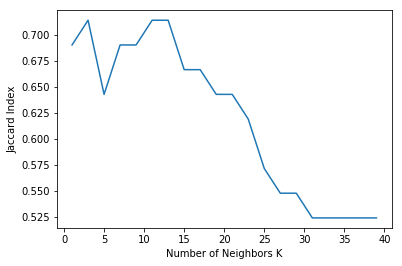

In [31]:
optimal_k_1 = neighbors[cv_scores_1.index(max(cv_scores_1))]
print('The optimal number of neighbors is %d' % optimal_k_1)

plt.plot(neighbors, cv_scores_1)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Jaccard Index')
plt.show()

 Notice that we have 3 peaks at  k=3, k=13, k=14 which have the highest Jaccard index, so it isn't suffisant to depend on just this mesure.

In [32]:
cv_scores_2 = []

for k in neighbors:
    if (k < 40) :
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores_2.append(scores.mean())

The optimal number of neighbors is 5


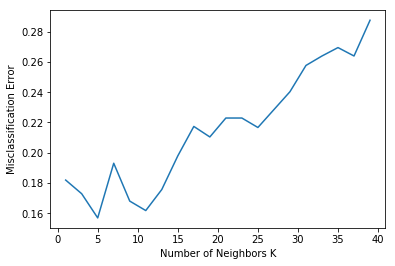

In [33]:
MSE = [1 - x for x in cv_scores_2]

optimal_k_2 = neighbors[MSE.index(min(MSE))]
print('The optimal number of neighbors is %d' % optimal_k_2)

plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

Thus now we can be confident in saying that data can be clustered to 5 classes just fine (and even if it is 3, and 5 had almost same Misclassification results we should take 5, as the labels depend on a strong variable which is Venue Price that takes 3 values, and we dont want our results to be biaised by a single feature)

### Conclusions

The biggest shortcoming of this project are pretty evident, unless a 400$ monthly subscription you have 500 premium calls per day to the Foursquare API, thus the dataset dimension is not impressive. Plus the definition of price range is pretty vague. Lastly Foursquare is not at all common in Morocco.

The best source for data is to do web scrapping but that would take so much time.

Hope you liked my notebook...
Thanks for reading